## Mask effectively all images

**Given**: STANDARADIZED_LIST with images and attached labels. 

1. <font color=blue>Quick Mask One</font> : Quickly manual trial and error for any particular image identified by its index in STANDARDIZED_LIST. With this one could tweak mask valuese for one particular image.  

2. <font color=blue>Quick Mask Few 1</font>: Apply same mask values to a couple of randomly selected images in STANDARDIZED_LIST. This helps to check how good our mask values across the images. Trying all 15xx images will take time, and we need to iterate fast, so random images.Note, in this step, mask is applied for each image as per attached label. 

3. <font color=blue>Quick Mask Few 2</font>: Almost above step, but all 3 color masks applied to each image. 

4. <font color=blue>Quick HSV Masked Few</font>: Apply same mask values, and calculate HSV sums for those masked images and see, if we could infer any thing? Are there always some distinction between these values for images of different labels.

Note we do all above steps interchangeably in tweaking the mask values. Any time, the animation in step 2 or 3 could be stopped for image where our values messed up, note down image ID, go back to step 1, tweak further and apply all over again. Since only couple of images randomly analyzed, all steps should not take much time. 

Also important, to quickly tweak mask value one has to grab the missed colors in original image. I highly recommend [eye dropper](http://instant-eyedropper.com/) tool, that sits in your quick tray (windows), and provide the color values of interest with mouse pointer.

Then one could simply grab a color picker, get the **openCV** compatable HSV values. I say openCV caz, most of HSV color pickers are of ranges (0-360, 0-100, 0-100). We need to convert to openCV's format: (0-180, 0-255, 0-255). 

### Step 1. Quick Mask One

Note, mask is inverted and applied, because we want not to mask the light area (red/yellow/green) but rest of the image, so we could differentiate later. So it is important, at least some part of signal implied should appear in the mask. If all masked out, we lost the signal info.

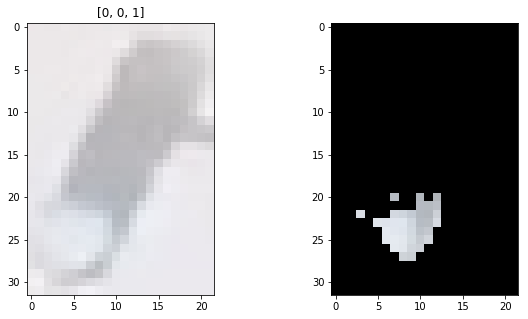

In [1]:
%matplotlib inline 
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np

#we get STANDARDIZED_LIST FROM A HELPER FILE
from loaders import STANDARDIZED_LIST

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

# 723 to 757 is yellow 
num = 1143
image = STANDARDIZED_LIST[num][0]
label = STANDARDIZED_LIST[num][1]
image = image[:, 5:-5, :]
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
if label[0] == 1: # red
    red_mask_hsv1 = cv2.inRange(image_hsv, (0,25,50), (12,255,255))
    red_mask_hsv2 = cv2.inRange(image_hsv, (150,25,50), (180,255,255))
    mask_hsv = cv2.bitwise_or(red_mask_hsv1,red_mask_hsv2)
elif label[1] == 1: # yellow     
    mask_hsv = cv2.inRange(image_hsv, (15,18,210),(31,255,255))   
else:
    mask_hsv = cv2.inRange(image_hsv,(33,12,120),(110,255,255))   
    
mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask to avoid rest of area
masked_image = np.copy(image)
masked_image[mask_hsv != 0] = [0, 0, 0]     
ax2.imshow(masked_image, cmap='gray')

ax1.set_title(label)
ax1.imshow(image)

### Step 2. Quick Mask Few 1

Animation runs at 1 sec per frame, so enough time to spot messed up mask. When you do, note down the ID, and try fixing mask values in Step 1 and try with the same values here. 

The goal is to capture at least few part of the implied signal and if possible none of other signal. for eg, from a red signal image, capture at least part of red, and none of green or yellow. 

It is ok, if for eg, red signal image, green and yellow masks also result in non-zero or extracting few parts of image. As long as red masked image is _dominant in some way_ (for eg, larger area comparitvely) we should be good to go. Soom we will try to find a threshold here. 

In [2]:
%matplotlib inline 
from IPython.display import Image, display, HTML
#from loaders import STANDARDIZED_LIST
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np
from random import randint


f, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

# 723 to 757 is yellow 
def animate(i):
    ax1.clear()
    ax2.clear()
    
    num = randint(0, len(STANDARDIZED_LIST))
    image = STANDARDIZED_LIST[num][0]
    label = STANDARDIZED_LIST[num][1]
    
    image = image[:, 5:-5, :]
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if label[0] == 1: # red
        
        ax2.set_title('This is red')
        red_mask_hsv1 = cv2.inRange(image_hsv, (0,25,50), (12,255,255))
        red_mask_hsv2 = cv2.inRange(image_hsv, (150,25,50), (180,255,255))
        mask_hsv = cv2.bitwise_or(red_mask_hsv1,red_mask_hsv2)
    elif label[1] == 1: # yellow     
        ax2.set_title('This is yellow')
        mask_hsv = cv2.inRange(image_hsv, (15,18,210),(31,255,255))   
    else:
        ax2.set_title('This is green')
        mask_hsv = cv2.inRange(image_hsv,(33,12,120),(110,255,255)) 
        
    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0]     
    ax2.imshow(masked_image, cmap='gray')
    
    ax1.set_title('ID: {}'.format(num))
    ax1.imshow(image)

anim = animation.FuncAnimation(f, animate, frames=10, interval=1000)

plt.close()
HTML(anim.to_html5_video())

### Step 2. Quick Mask Few 2

All 3 masks (red, green, yellow) applied to each images. Goal is to see, if red mask, extracts red signal image appropriately, while green and yellow masks simply blacks out. Then we could easily compare all 3 masks of the images to infer if original image is red (this we will derive programmatically shortly)

Make sure, to run many times and observe, if masks are extracting appropriately. 

Below would be the layout.

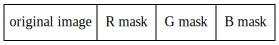

In [3]:
#!conda install graphviz
from graphviz import Digraph
layout = Digraph('structs', node_attr={'shape': 'record'})
layout.node('struct1', "original image | R mask | G mask | B mask")
layout

In [4]:
%matplotlib inline 
from IPython.display import Image, display, HTML
#from loaders import STANDARDIZED_LIST
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np
from random import randint


f, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,5))

# 723 to 757 is yellow 
def animate(i):
    ax1.clear()
    ax2.clear()
    
    num = randint(0, len(STANDARDIZED_LIST))
    image = STANDARDIZED_LIST[num][0]
    label = STANDARDIZED_LIST[num][1]
    
    image = image[:, 5:-5, :]
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # red
    ax2.set_title('Red Mask')
    red_mask_hsv1 = cv2.inRange(image_hsv, (0,25,50), (12,255,255))
    red_mask_hsv2 = cv2.inRange(image_hsv, (150,25,50), (180,255,255))
    mask_hsv = cv2.bitwise_or(red_mask_hsv1,red_mask_hsv2)
    
    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0]     
    ax2.imshow(masked_image, cmap='gray')

    # yellow
    ax3.set_title('Yellow Mask')
    mask_hsv = cv2.inRange(image_hsv, (15,18,210),(31,255,255))   

    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0]     
    ax3.imshow(masked_image, cmap='gray')
    
    # green
    ax4.set_title('Green Mask')
    mask_hsv = cv2.inRange(image_hsv,(33,12,120),(110,255,255)) 
        
    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0]     
    ax4.imshow(masked_image, cmap='gray')
    
    ax1.set_title('ID: {}'.format(num))
    ax1.imshow(image)

anim = animation.FuncAnimation(f, animate, frames=10, interval=1000)

plt.close()
HTML(anim.to_html5_video())

Above masks look appropriate for now. So let us proceed.

### Step 3. Quick HSV Masked Few

Let us compare the RGB and HSV sums of these masked images. Below is the proposed layout. Axes numbers given for easier design. We need a 4x4 layout.

In [5]:
# thank you: https://github.com/foutaise/texttable/
from texttable import Texttable
table = Texttable()
table.add_rows([
                ['Original Image(0,0)', ' ', ' ',' '],
                ['R Mask(1,0)', 'H Sum(1,1)', 'S Sum(1,2)','V Sum(1,3)'],
                ['G Mask(2,0)', 'H Sum(2,1)', 'S Sum(2,2)','V Sum(2,3)'],    
                ['B Mask(3,0)', 'H Sum(3,1)', 'S Sum(3,2)','V Sum(3,3)'],        
              ])
print(table.draw() + '\n')

+---------------------+------------+------------+------------+
| Original Image(0,0) |            |            |            |
+=====================+============+============+============+
| R Mask(1,0)         | H Sum(1,1) | S Sum(1,2) | V Sum(1,3) |
+---------------------+------------+------------+------------+
| G Mask(2,0)         | H Sum(2,1) | S Sum(2,2) | V Sum(2,3) |
+---------------------+------------+------------+------------+
| B Mask(3,0)         | H Sum(3,1) | S Sum(3,2) | V Sum(3,3) |
+---------------------+------------+------------+------------+



In [6]:
%matplotlib inline 
from IPython.display import Image, display, HTML
#from loaders import STANDARDIZED_LIST
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np
from random import randint


f, axArray = plt.subplots(4, 4, figsize=(10,5))
f.tight_layout()
plt.subplots_adjust(bottom=0.11)

def getMaskedImage(image, label):
    """
    Returns the masked image as per label specified. For eg, label as 'Red' would 
    result in red areas extracted out of incoming image, and resultant image returned.
    NOTE INCOMING IMAGE IS RGB (if you used cv.imread,it would be BGR. I used matplotlib imread)
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if label is 'red':
        red_mask_hsv1 = cv2.inRange(image_hsv, (0,25,50), (12,255,255))
        red_mask_hsv2 = cv2.inRange(image_hsv, (150,25,50), (180,255,255))
        mask_hsv = cv2.bitwise_or(red_mask_hsv1,red_mask_hsv2)
    elif label is 'yellow':
        mask_hsv = cv2.inRange(image_hsv, (15,18,210),(31,255,255))   
    else: # green
        mask_hsv = cv2.inRange(image_hsv,(33,12,120),(110,255,255)) 
        
    # standard mask operations to extract out specified label color
    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0] 
    
    return masked_image

def getHSVSum(image):
    """
    Input: RGB image (ensure, its not BGR)
    Output: HSV sums individually
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # HSV channels
    h = image_hsv[:,:,0]
    s = image_hsv[:,:,1]
    v = image_hsv[:,:,2]
    h_sum = np.sum(h[:,:],axis=1)
    s_sum = np.sum(s[:,:],axis=1)
    v_sum = np.sum(v[:,:],axis=1)    
    
    return (h_sum, s_sum, v_sum)

# 723 to 757 is yellow 
def animate(i):
    
    # get the image
    num = randint(0, len(STANDARDIZED_LIST))
    image = STANDARDIZED_LIST[num][0]
    
    # crop it
    image = image[:, 5:-5, :]    
    
    # initialize axes
    [axArray[i,j].clear() for i in range(0,4) for j in range(0,4)] # clear for fresh plot
    [axArray[i,j].set_ylim([0,6000]) for i in range(0,4) for j in range(1,4)]
    axArray[0,0].set_title('ID: {}'.format(num))    
    axArray[0,1].set_title('H Sum')
    axArray[0,2].set_title('S Sum')
    axArray[0,3].set_title('V Sum')    
    
    # original image
    (h_sum, s_sum, v_sum) = getHSVSum(image)   # HSV sums of masked image (in RGB)   
    axArray[0,0].imshow(image)        
    axArray[0,1].plot(h_sum)
    axArray[0,2].plot(s_sum)
    axArray[0,3].plot(v_sum)   
       
    labels = ['red', 'yellow', 'green']
    
    for i in range(1,4):
        
        # per row operation
        label = labels[i-1]
        masked_image = getMaskedImage(image,label)        # masked image
        hsv_sum = getHSVSum(masked_image)   # HSV sums of masked image
        axArray[i,0].set_title(label + 'mask')    
        axArray[i,0].imshow(masked_image, cmap='gray')        
        
        # per cell operation
        for j in range(1,4):
            axArray[i,j].plot(hsv_sum[j-1])
            
        

anim = animation.FuncAnimation(f, animate, frames=10, interval=1000)

plt.close()
HTML(anim.to_html5_video())

Note
1. For red signal image, the red mask graphs mostly have some HSV values, while other masks are almost nil. Similar for yellow and green. This is a good measure already.  
2. Unlike individual masked image, HSV of original image is kinda inconclusive with some HSV values spread all across for all labels. 

Now that we could do HSV, we will also check RGB sums. 

In [7]:
%matplotlib inline 
from IPython.display import Image, display, HTML
#from loaders import STANDARDIZED_LIST
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np
from random import randint


f, axArray = plt.subplots(4, 4, figsize=(10,5))
f.tight_layout()
plt.subplots_adjust(bottom=0.11)

def getMaskedImage(image, label):
    """
    Returns the masked image as per label specified. For eg, label as 'Red' would 
    result in red areas extracted out of incoming image, and resultant image returned.
    NOTE INCOMING IMAGE IS RGB (if you used cv.imread,it would be BGR. I used matplotlib imread)
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if label is 'red':
        red_mask_hsv1 = cv2.inRange(image_hsv, (0,25,50), (12,255,255))
        red_mask_hsv2 = cv2.inRange(image_hsv, (150,25,50), (180,255,255))
        mask_hsv = cv2.bitwise_or(red_mask_hsv1,red_mask_hsv2)
    elif label is 'yellow':
        mask_hsv = cv2.inRange(image_hsv, (15,18,210),(31,255,255))   
    else: # green
        mask_hsv = cv2.inRange(image_hsv,(33,12,120),(110,255,255)) 
        
    # standard mask operations to extract out specified label color
    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0] 
    
    return masked_image

def getRGBSum(image):
    """
    Input: RGB image (ensure, its not BGR)
    Output: RGB sums individually
    """
    # first convert to HSV
    #image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # HSV channels
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]
    r_sum = np.sum(r[:,:],axis=1)
    g_sum = np.sum(g[:,:],axis=1)
    b_sum = np.sum(b[:,:],axis=1)    
    
    return (r_sum, g_sum, b_sum)


def getHSVSum(image):
    """
    Input: RGB image (ensure, its not BGR)
    Output: HSV sums individually
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # HSV channels
    h = image_hsv[:,:,0]
    s = image_hsv[:,:,1]
    v = image_hsv[:,:,2]
    h_sum = np.sum(h[:,:],axis=1)
    s_sum = np.sum(s[:,:],axis=1)
    v_sum = np.sum(v[:,:],axis=1)    
    
    return (h_sum, s_sum, v_sum)

# 723 to 757 is yellow 
def animate(i):
    
    # get the image
    num = randint(0, len(STANDARDIZED_LIST))
    image = STANDARDIZED_LIST[num][0]
    
    # crop it
    image = image[:, 5:-5, :]    
    
    # initialize axes
    [axArray[i,j].clear() for i in range(0,4) for j in range(0,4)] # clear for fresh plot
    [axArray[i,j].set_ylim([0,6000]) for i in range(0,4) for j in range(1,4)]
    axArray[0,0].set_title('ID: {}'.format(num))    
    axArray[0,1].set_title('R Sum')
    axArray[0,2].set_title('G Sum')
    axArray[0,3].set_title('B Sum')    
    
    # original image
    (r_sum, g_sum, b_sum) = getRGBSum(image)   # HSV sums of masked image (in RGB)   
    axArray[0,0].imshow(image)        
    axArray[0,1].plot(r_sum)
    axArray[0,2].plot(g_sum)
    axArray[0,3].plot(b_sum)   
       
    labels = ['red', 'yellow', 'green']
    
    for i in range(1,4):
        
        # per row operation
        label = labels[i-1]
        masked_image = getMaskedImage(image,label)        # masked image
        rgb_sum = getRGBSum(masked_image)   # HSV sums of masked image
        axArray[i,0].set_title(label + 'mask')    
        axArray[i,0].imshow(masked_image, cmap='gray')        
        
        # per cell operation
        for j in range(1,4):
            axArray[i,j].plot(rgb_sum[j-1])
            
        

anim = animation.FuncAnimation(f, animate, frames=10, interval=1000)

plt.close()
HTML(anim.to_html5_video())

At this moment, all sums in HSV, RGB are looking good enough for comparisons. But udacity stressed brightness feature to be used, so we will go with that. Before that, let us check out the running averages of these sums across the image (sum/area). For eg, V sum/area could give average brightness of an image. 

In [8]:
%matplotlib inline 
from IPython.display import Image, display, HTML
#from loaders import STANDARDIZED_LIST
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np
from random import randint


f, axArray = plt.subplots(4, 4, figsize=(10,5))
f.tight_layout()
plt.subplots_adjust(bottom=0.11)

def getMaskedImage(image, label):
    """
    Returns the masked image as per label specified. For eg, label as 'Red' would 
    result in red areas extracted out of incoming image, and resultant image returned.
    NOTE INCOMING IMAGE IS RGB (if you used cv.imread,it would be BGR. I used matplotlib imread)
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if label is 'red':
        red_mask_hsv1 = cv2.inRange(image_hsv, (0,25,50), (12,255,255))
        red_mask_hsv2 = cv2.inRange(image_hsv, (150,25,50), (180,255,255))
        mask_hsv = cv2.bitwise_or(red_mask_hsv1,red_mask_hsv2)
    elif label is 'yellow':
        mask_hsv = cv2.inRange(image_hsv, (15,18,210),(31,255,255))   
    else: # green
        mask_hsv = cv2.inRange(image_hsv,(33,12,120),(110,255,255)) 
        
    # standard mask operations to extract out specified label color
    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0] 
    
    return masked_image

def getHSVSum(image):
    """
    Input: RGB image (ensure, its not BGR)
    Output: HSV sums individually
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # HSV channels
    h = image_hsv[:,:,0]
    s = image_hsv[:,:,1]
    v = image_hsv[:,:,2]
    h_sum = np.sum(h[:,:],axis=1)
    s_sum = np.sum(s[:,:],axis=1)
    v_sum = np.sum(v[:,:],axis=1)    
    
    return (h_sum, s_sum, v_sum)


# 723 to 757 is yellow 
def animate(i):
    
    # get the image
    num = randint(0, len(STANDARDIZED_LIST))
    image = STANDARDIZED_LIST[num][0]
    (width,height,_) = image.shape
    area = width*height    
    
    # crop it
    image = image[:, 5:-5, :]    
    
    # initialize axes
    [axArray[i,j].clear() for i in range(0,4) for j in range(0,4)] # clear for fresh plot
    [axArray[i,j].set_ylim([0,6000]) for i in range(0,4) for j in range(1,4)]
    axArray[0,0].set_title('ID: {}'.format(num))    
    axArray[0,1].set_title('H Sum')
    axArray[0,2].set_title('S Sum')
    axArray[0,3].set_title('V Sum')    
    
    # original image
    hsv_sum = getHSVSum(image)   # HSV sums of masked image (in RGB)   
    axArray[0,0].imshow(image)        
    #axArray[0,1].plot(hsv_sum[0])
    #axArray[0,2].plot(hsv_sum[1])
    #axArray[0,3].plot(hsv_sum[2])   
    [axArray[0,j].plot(hsv_sum[j-1]) for j in range(1,4)]
       
    labels = ['red', 'yellow', 'green']
    
    for i in range(1,4):
        
        # per row operation
        label = labels[i-1]
        masked_image = getMaskedImage(image,label)        # masked image
        axArray[i,0].set_title(label + 'mask')    
        axArray[i,0].imshow(masked_image, cmap='gray')        
        
        hsv_sum = getHSVSum(masked_image)   # HSV sums of masked image        
        
        # per cell operation
        for j in range(1,4):
            summy = hsv_sum[j-1]
            average = round(np.sum(summy)/area,1)            
            axArray[i,j].plot(summy)
            axArray[i,j].annotate(average,xy=(0.7, 0.7), xycoords="axes fraction")

                    

anim = animation.FuncAnimation(f, animate, frames=10, interval=1000)

plt.close()
HTML(anim.to_html5_video())

It is kinda getting difficult to compare the numerical values, so we will derive entire HSV sums for all masked iamges for all labels separately. Layout is something like below. 